In [44]:
# !pip install -U uv
!uv venv .scvi-env
!.scvi-env\Scripts\activate  # for Windows

Using CPython 3.10.16 interpreter at: C:\Users\musad\anaconda3\python.exe
Creating virtual environment at: .scvi-env
Activate with: .scvi-env\Scripts\activate


!pip install -U scvi-tools scib-metrics

In [45]:
import os
import tempfile

import pandas as pd
import scanpy as sc
from scipy.sparse import csc_matrix
import scvi
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from eval_utils import performance_scores
from rich import print
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

import warnings
warnings.filterwarnings("ignore")

In [46]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.0

In [47]:
# Load data (cells x genes)
count_data = pd.read_csv("E:/BLCA-031-01-1A.counts.matrix.tsv/BLCA-031-01-1A.counts.matrix.tsv", sep="\t", index_col=0)
metadata = pd.read_csv("E:/BLCA-031-01-1A.counts.matrix.tsv/BLCA-031-01-1A.cell.type.txt", sep="\t")

# Ensure the metadata index matches the count data index
metadata = metadata.set_index('Cell')
metadata = metadata.reindex(count_data.T.index)

In [48]:
# Convert to AnnData format
adata = sc.AnnData(count_data.T, obs=metadata)
adata.layers["counts"] = csc_matrix(adata.X.copy())

In [51]:
# Preprocessing
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=10)  # Remove low-expressed genes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [52]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True
)

# scVI

In [ ]:
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts",
                              batch_key=None
)

In [54]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [55]:
scvi_model.train(max_epochs=30)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [56]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(count_data.T, metadata, test_size=0.2, random_state=42, stratify=metadata)
train_index = y_train.index.values
test_index = y_test.index.values

In [57]:
X_latent = adata.obsm["X_scVI"]
y_all = adata.obs["cell_type"]

X_train = X_latent[adata.obs_names.isin(train_index)]
y_train = y_all[adata.obs_names.isin(train_index)]

X_test = X_latent[adata.obs_names.isin(test_index)]
y_test = y_all[adata.obs_names.isin(test_index)]

In [58]:
# 4. Train classifier
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [59]:
# 5. Predict
y_pred = clf.predict(X_test)
adata.obs.loc[test_index, "scVI_predicted_labels"] = y_pred

In [60]:
# 5. Evaluate
performance_scores(y_test, y_pred)

Confusion Matrix:
 [[  21   11    0    0    0    0    0    2    0    0    1    0    0    0
     0]
 [   6   43    0    0    3    0    1    3    0    0    1    0    0    0
     0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    0    0
     0]
 [   0    3    0    0    5    0    0    1    0    0    0    0    0    0
     0]
 [   0    1    0    0    0    0    0    1    0    0    0    0    0    0
     0]
 [   0    3    0    0    6    0    5    0    0    0    0    0    0    0
     0]
 [   1    3    0    0    4    0    1    1    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    7    3    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    1   12    0    0    0    0
     0]
 [   0    0    0    0    0    0    1    0    0    0 1173    0    0    0
     1]
 [   0    0    0    0    0    0    0    0    1    1    0    0    0    0
     1]
 [   0    0    0    0

,Accuracy,Balanced Accuracy,Precision,Recall (Sensitivity),Specificity,F1-score (Weighted),F1-score (Macro),Matthews Corrcoef (MCC),Cohen's Kappa
0,0.94494,0.365897,0.941508,0.94494,0.995216,0.941977,0.35779,0.762869,0.762595


In [61]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
adata.obs.loc[test_index, "scVI_knn_labels"] = y_pred

In [62]:
performance_scores(y_test, y_pred)

Confusion Matrix:
 [[  23   11    0    0    0    0    0    1    0    0    0    0    0    0
     0]
 [   9   42    0    0    2    0    4    0    0    0    0    0    0    0
     0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    0    0
     0]
 [   0    4    0    0    5    0    0    0    0    0    0    0    0    0
     0]
 [   0    1    0    0    0    0    0    1    0    0    0    0    0    0
     0]
 [   0    3    0    0    5    0    6    0    0    0    0    0    0    0
     0]
 [   2    2    0    0    5    0    1    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    8    2    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    1   12    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0 1174    0    0    0
     1]
 [   0    0    0    0    0    0    0    0    1    2    0    0    0    0
     0]
 [   0    0    0    0

,Accuracy,Balanced Accuracy,Precision,Recall (Sensitivity),Specificity,F1-score (Weighted),F1-score (Macro),Matthews Corrcoef (MCC),Cohen's Kappa
0,0.945685,0.351134,0.940527,0.945685,0.996295,0.941039,0.329576,0.767334,0.767015


In [63]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

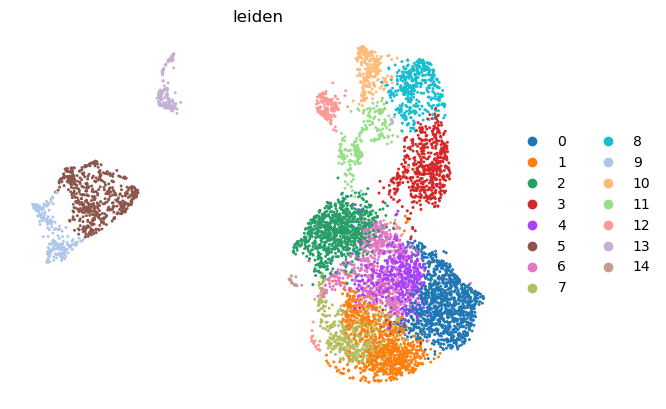

In [64]:
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
    ncols=1,
)

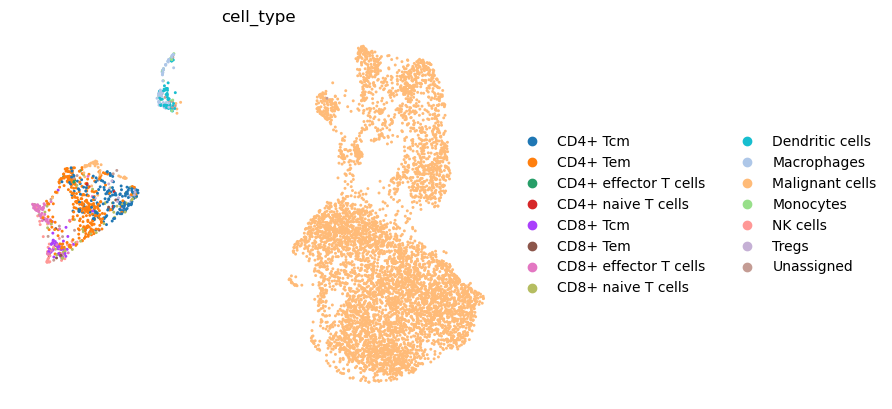

In [65]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

# scANVI

In [ ]:
labels = metadata.copy()
labels.loc[test_index, 'cell_type'] = "Unknown"
adata.obs["celltype_scanvi"] = labels

In [66]:
scvi.model.SCANVI.setup_anndata(adata,
                                layer="counts",
                                batch_key=None,
                                labels_key="celltype_scanvi",
                                unlabeled_category='Unknown'
)

In [67]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="celltype_scanvi",
    unlabeled_category="Unknown"
)

In [68]:
scanvi_model.train(max_epochs=30)

INFO     Training for 30 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [69]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

In [70]:
y_true = adata.obs.loc[test_index, "cell_type"]
y_pred = adata.obs.loc[test_index, "C_scANVI"]

In [79]:
performance_scores(y_true, y_pred)

Confusion Matrix:
 [[  18   13    0    0    0    0    0    3    0    0    1    0    0    0
     0]
 [   5   41    0    0    7    1    0    3    0    0    0    0    0    0
     0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    0    0
     0]
 [   0    4    0    0    5    0    0    0    0    0    0    0    0    0
     0]
 [   1    0    0    0    0    0    0    1    0    0    0    0    0    0
     0]
 [   0    1    0    0    7    2    4    0    0    0    0    0    0    0
     0]
 [   2    2    0    0    1    2    0    1    0    0    0    0    2    0
     0]
 [   0    0    0    0    0    0    0    0    7    3    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0   13    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0 1174    0    0    0
     1]
 [   0    0    0    0    0    0    0    0    2    1    0    0    0    0
     0]
 [   0    0    0    0

,Accuracy,Balanced Accuracy,Precision,Recall (Sensitivity),Specificity,F1-score (Weighted),F1-score (Macro),Matthews Corrcoef (MCC),Cohen's Kappa
0,0.943452,0.380489,0.944323,0.943452,0.995462,0.94093,0.361993,0.756673,0.756305


In [80]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [81]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.leiden(adata)

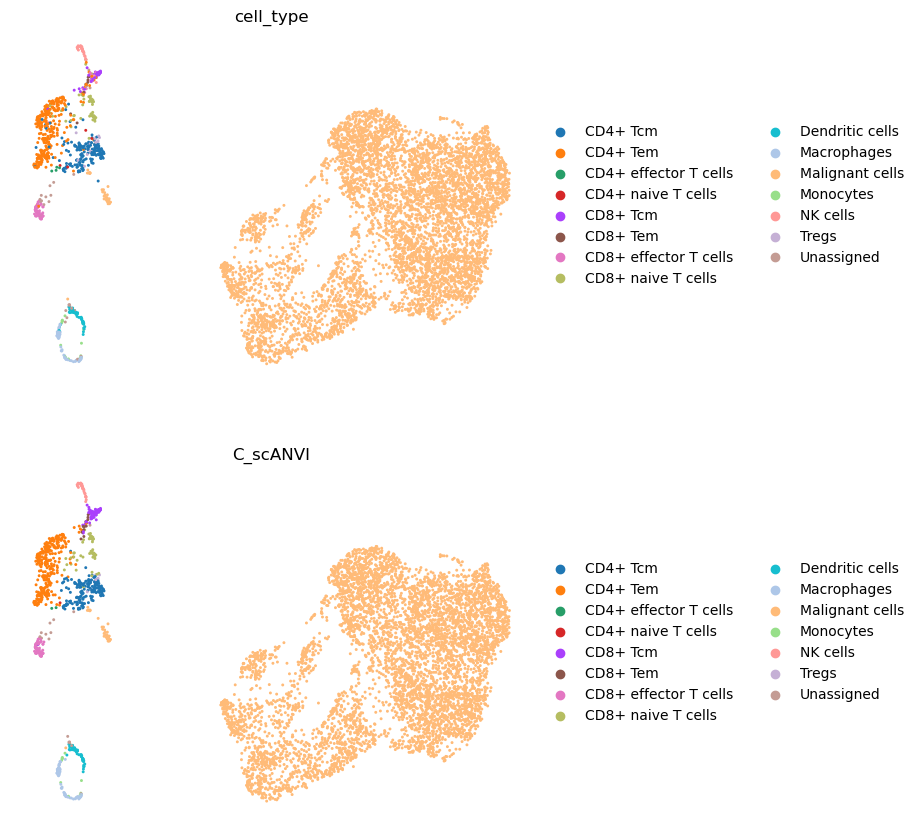

In [82]:
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["cell_type", "C_scANVI"],
    frameon=False,
    ncols=1,
)